# 策略参数选择

In [1]:
import os
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')

import numpy as np
import pandas as pd
import seaborn as sns
from empyrical import sharpe_ratio, max_drawdown

from utils import query, select_by_quantile, plot_curves
from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    cal_ret,
    cal_daily_ret, 
    standardize,
)

sns.set_style('darkgrid')

db_name = 'C73'
col = 'daily'
PARAMS = dict(trs=0.12, lqk_width=0.1, lqk_floor=0.5)

In [2]:
length_rng = range(20, 130, 10)
ema_length_rng = range(50, 325, 25)

params_list = [
    (length, ema_length) 
    for length in length_rng
    for ema_length in ema_length_rng
]

CUM_RET_DICT = {
    (length, ema_length): avg_cum_ret_from_cursor(
        query(db_name, col, length=length, ema_length=ema_length, **PARAMS)
    )                
    for length in length_rng 
    for ema_length in ema_length_rng
}

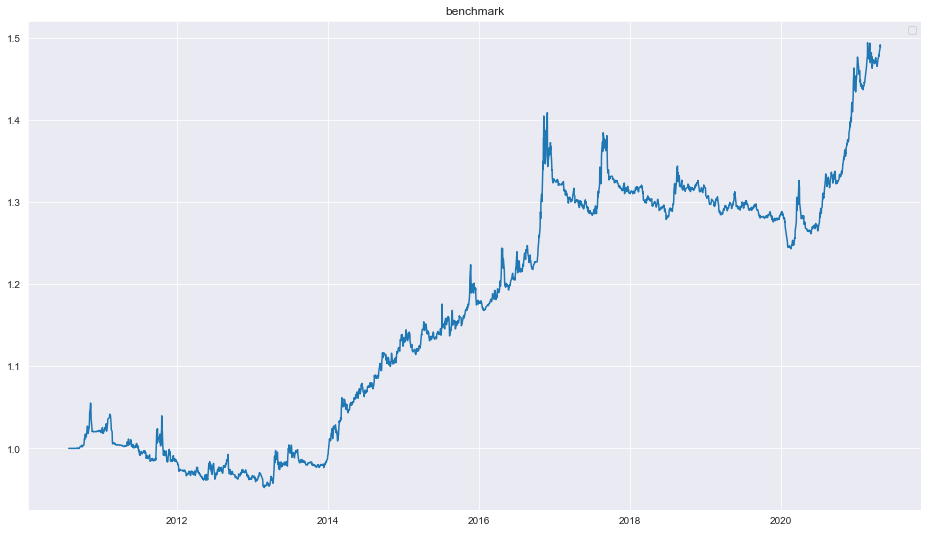

In [3]:
benchmark = cal_avg_cum_ret(CUM_RET_DICT.values())
plot_curves([benchmark], 'benchmark', [])

In [4]:
def dynamicly_choose_params(freq: str, sort_fn: "<class 'function'>", quantile:tuple=(0, 0.2), start='2010-01-01', end='2022-01-01'): 
    """
    将整个回测区间分为若干个周期，用前一个周期的数据将参数排序并选出某个分位数上的参数，
    在下一期选择该参数，滚动地构建出一条收益率曲线。
    
    (与动态选择品种逻辑十分相似，可考虑将两者重构为同一个函数)
    
    params:
        - freq: 持仓调整频率。
        - sort_fn：使用历史数据将参数排序的某种规则。
        - quantile: 选出的参数排序后的分位数。
        - start: 回测开始日期
        - end: 回测结束日期
    """
    # 调仓时间
    times = pd.date_range(start=start, end=end, freq=freq).to_pydatetime()
    
    avg_cum_rets = []
    for pre_t, t, next_t in zip(times[:-2], times[1:-1], times[2:]):
        
        # 选择在历史期和预测期的都有收益率的参数
        # pre_t 到 t 为历史期, t 到 next_t为预测期。
        history_data = {
            c: cum_ret.loc[pre_t: t].iloc[1:] 
            for c, cum_ret in CUM_RET_DICT.items()
            if cum_ret.index[0] < t and cum_ret.index[-1] > t
        }
        
        # 根据选取规则选择参数以及它们在预测期的平均收益率（预测期不包括下一个调仓日期）
        sorted_params = sorted(history_data.keys(), 
                               key=lambda c: sort_fn(history_data[c]), 
                               reverse=True)
        selected_params = select_by_quantile(sorted_params, quantile[0], quantile[1])
        future_cum_rets = filter(
            lambda x: len(x) > 0, 
            [CUM_RET_DICT[c].loc[t: next_t] for c in selected_params]
        )
        
        # 将收益率曲线标准化, 并去除第一项避免与上一期重复
        future_cum_rets = [standardize(cr).iloc[1:] for cr in future_cum_rets]
        avg_cum_ret = cal_avg_cum_ret(future_cum_rets)
        avg_cum_rets.append(avg_cum_ret)
    
    # todo；在拼接累计收益率曲线时考虑换仓交易成本
    return cal_avg_cum_ret(avg_cum_rets)

## 构建选择标准

In [5]:
freqs = ['180D', '360D', '540D']
quantiles = quantiles = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]

### 1. 收益率
将策略上一期收益率作为分组标准，进行分位数测试。  
调仓日期为180天时，策略表现出了较明显的反转效应。
调仓日期为360天、540天时无显著效应。

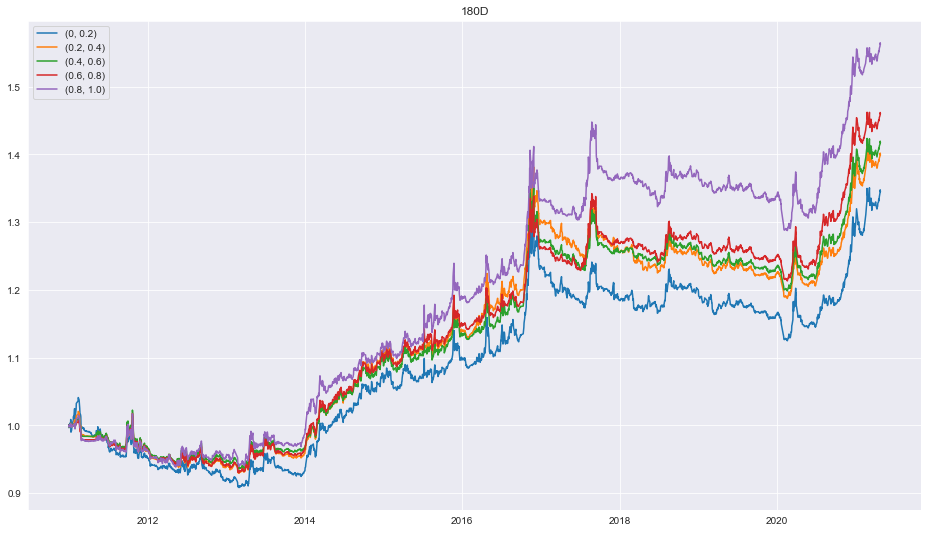

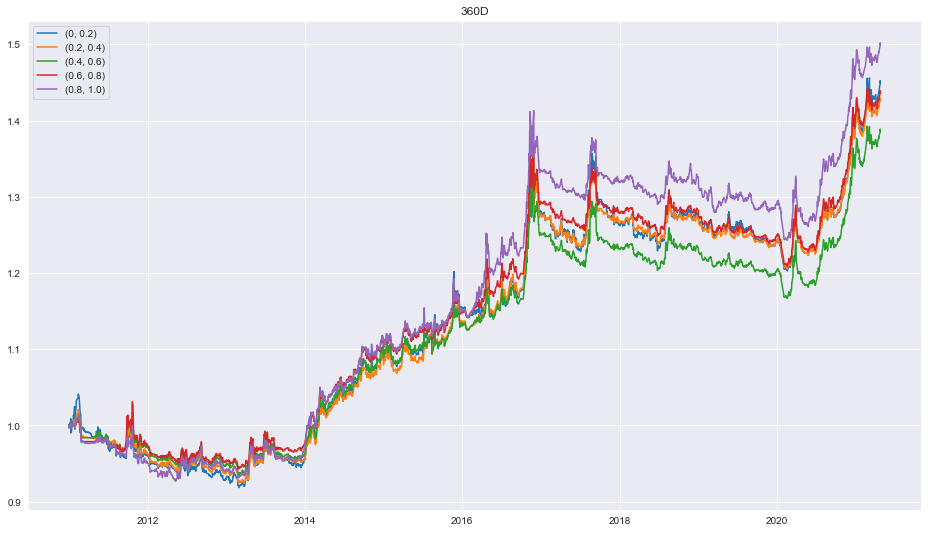

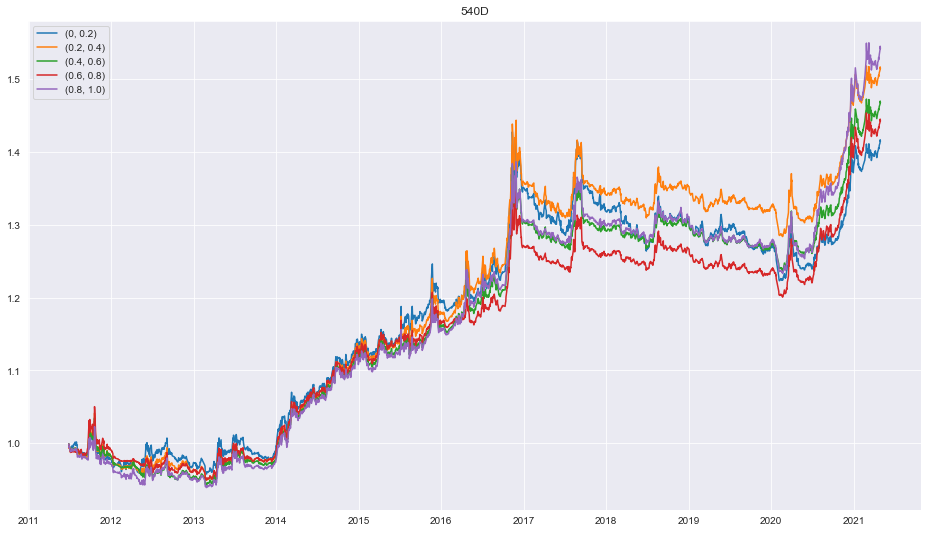

In [6]:
def return_rate(cum_ret):
    """计算收益率"""
    return cum_ret.values[-1] / cum_ret.values[0] - 1


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_params(freq=freq, 
                                                   sort_fn=return_rate, 
                                                   quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)

### 2. Sharpe
将策略上一期sharpe作为分组标准，进行分位数测试。  
调仓日期为180天、360天、540天时均无显著效应。

d:\python\lib\site-packages\empyrical\stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,


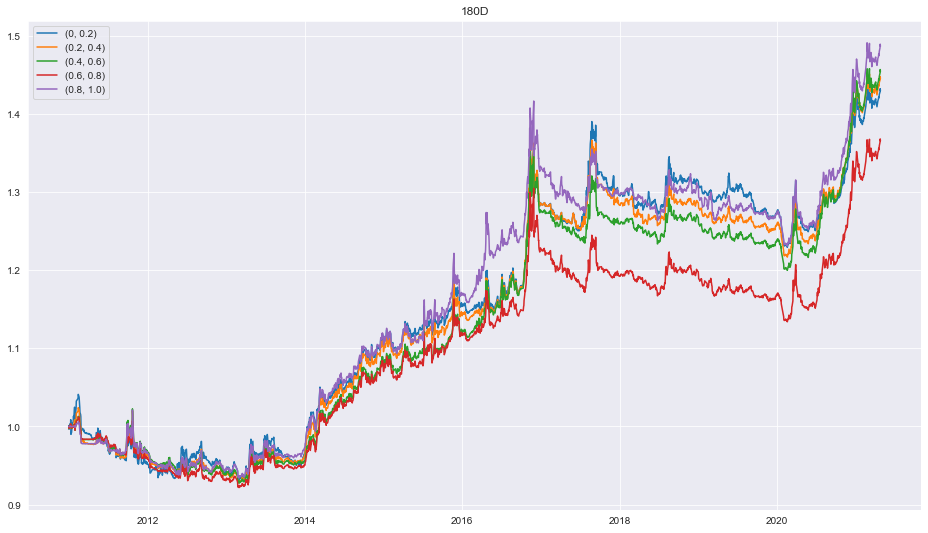

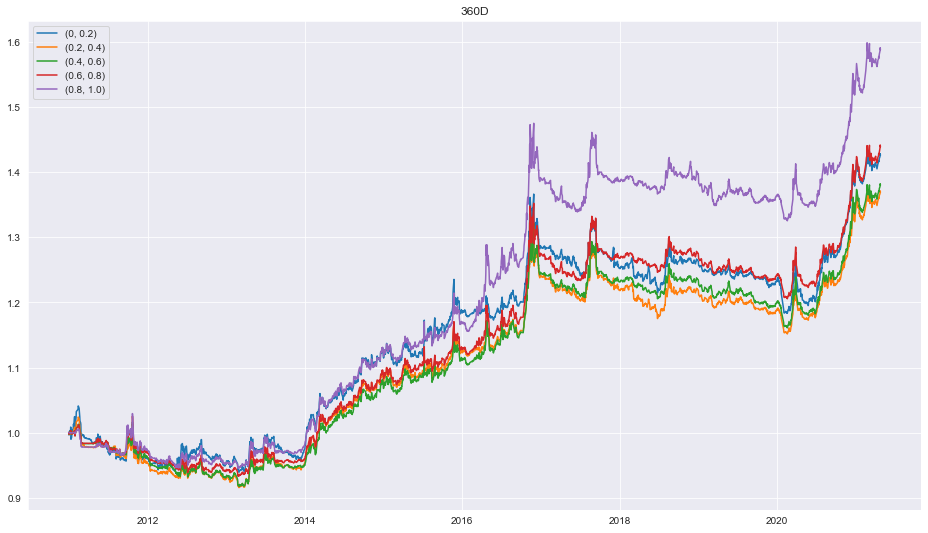

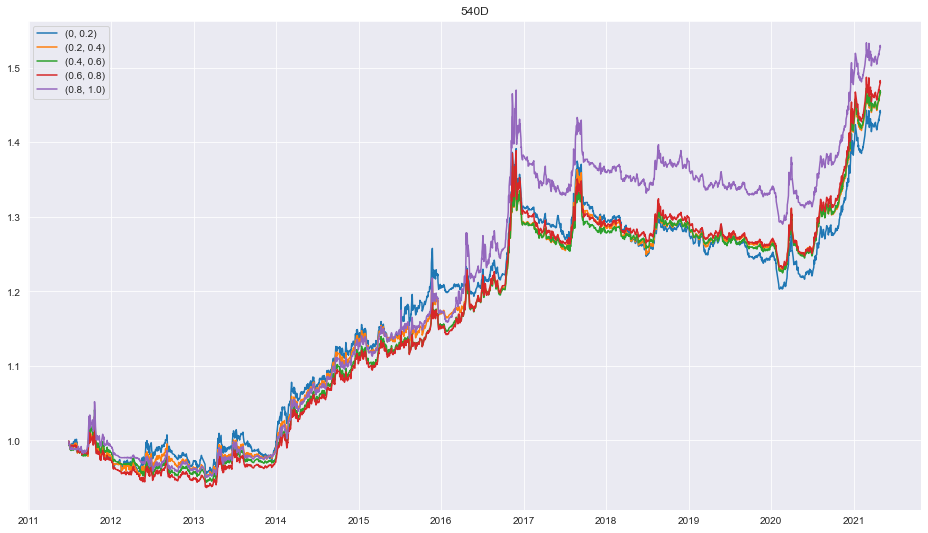

In [7]:
def sharpe(cum_ret):
    daily_ret = cal_daily_ret(cum_ret)
    return sharpe_ratio(daily_ret, period='daily')

for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_params(freq=freq, 
                                                   sort_fn=sharpe, 
                                                   quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)

### 3. 最大回撤（取相反数）
将策略上一期最大回撤相反数作为分组标准，进行分位数测试（即排名越靠前的参数回撤越小）。  
调仓日期为180天、360天、540天时，回撤最小的前两组参数均能在下一期有更好的表现，但后三组参数的收益率未能按分位数顺序排列。

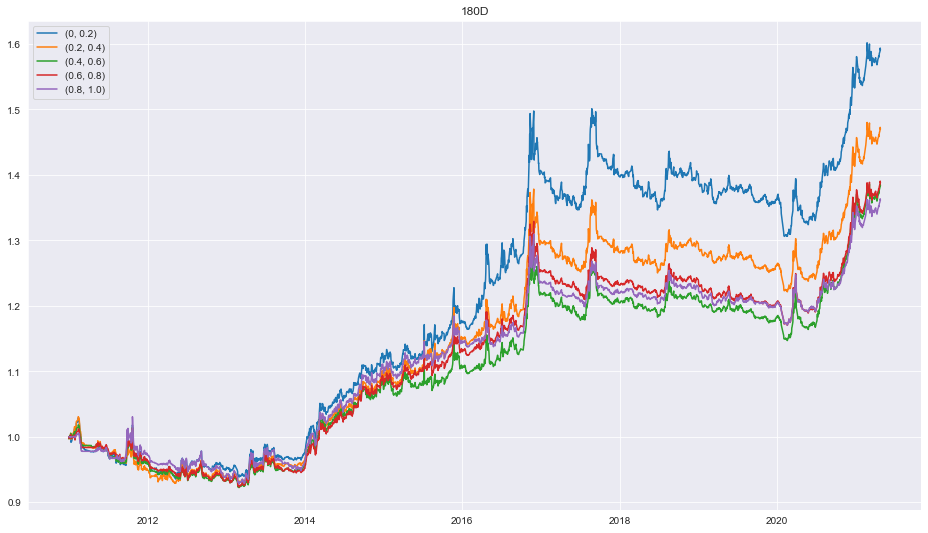

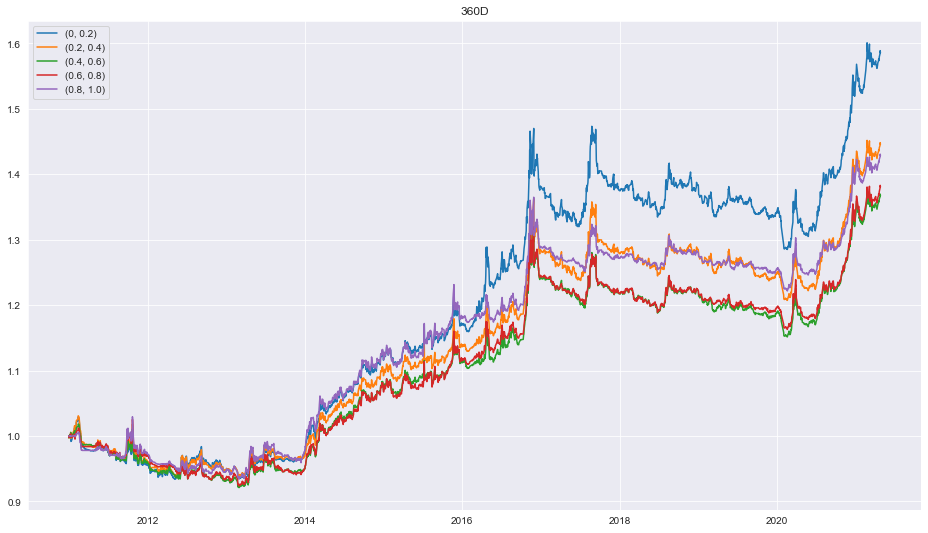

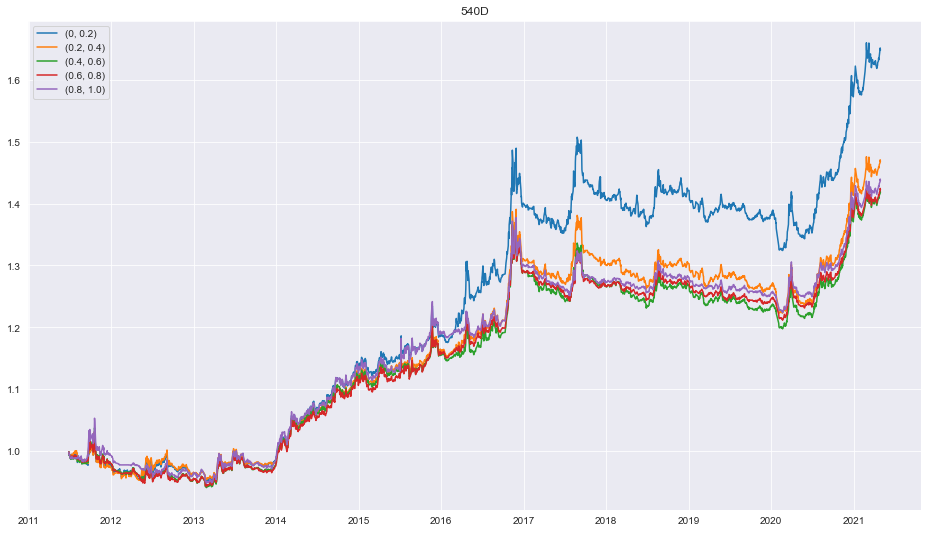

In [8]:
def negative_max_drawdown(cum_ret):
    daily_ret = cal_daily_ret(cum_ret)
    return -max_drawdown(daily_ret)


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_params(freq=freq, 
                                                   sort_fn=negative_max_drawdown, 
                                                   quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)

### 4. 胜率
将策略上一期胜率作为分组标准，进行分位数测试。  
调仓日期为180天、360天、540天时，五组组参数均能按分位数顺序排列（但第四组和第五组差距不大）。

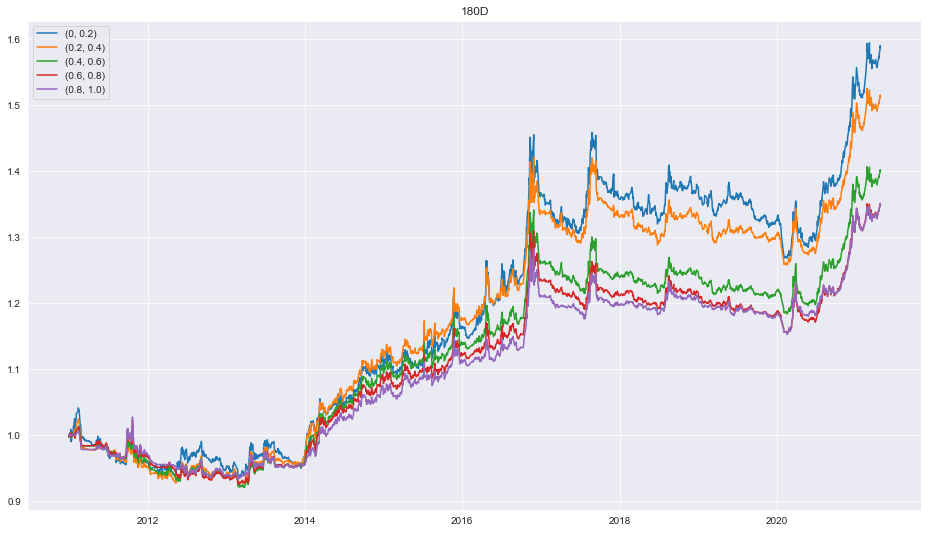

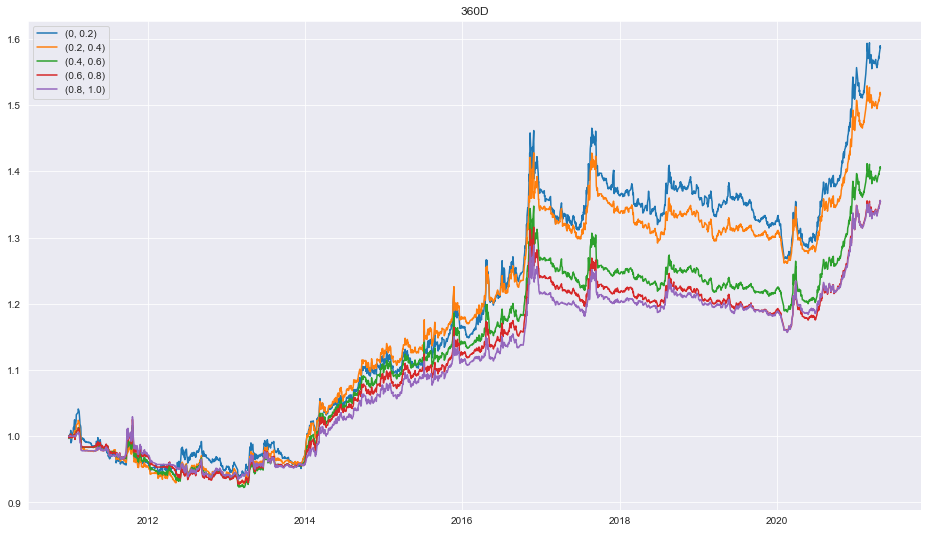

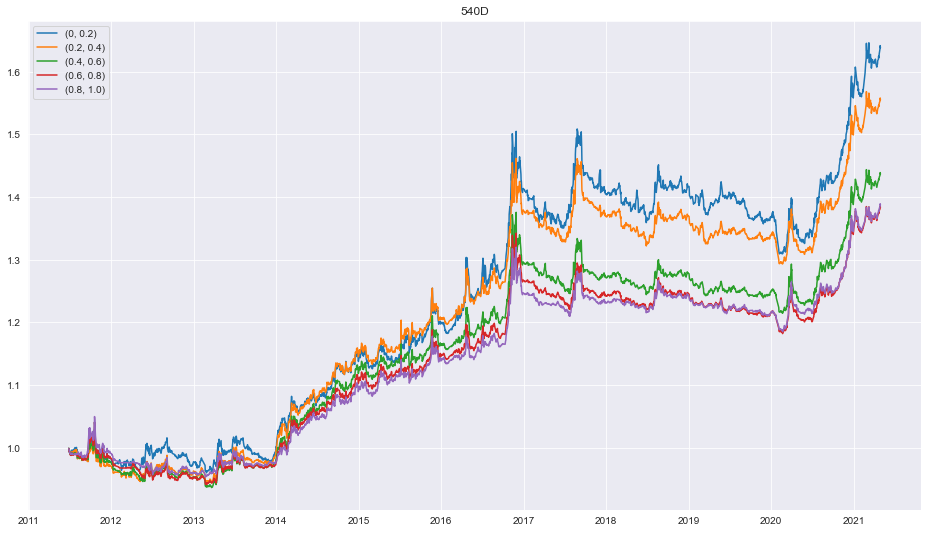

In [9]:
def win_rate(cum_ret):
    ret = cal_ret(cum_ret) 
    return len(ret[ret > 0]) / len(ret)


for freq in freqs:
    cum_ret_by_quantile = [dynamicly_choose_params(freq=freq, 
                                                   sort_fn=win_rate, 
                                                   quantile=quantile) 
                           for quantile in quantiles]
    plot_curves(cum_ret_by_quantile, freq, quantiles)